# Import libraries

In [1]:
import random
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.svm as svm
import seaborn as sns
%matplotlib inline

# Function initialization

In [2]:
def func_confusion_matrix(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    unique_values = set(y_pred)
    sorted(unique_values)
    num_classes = len(unique_values)
    unique_values = np.array(list(unique_values)) # change to array so can use indexes
    possible_string_dict = {}
    # make sure all values are 0 based, so can use built-in "zip" function
    if(issubclass(type(y_test[0]), np.integer)): # if values are integers
        y_test_min = y_test.min()
        if(y_test_min != 0):# if does not contain 0, reduce both test and pred by min value to get 0 based for both
            y_test = y_test - y_test_min
            y_pred = y_pred - y_test_min
    else:
        y_test_int = np.empty(len(y_test), dtype=int)
        y_pred_int = np.empty(len(y_pred), dtype=int)
        for index in range(0, num_classes):
            current_value = unique_values[index]
            possible_string_dict[index] = current_value
            y_test_int[y_test == current_value] = index
            y_pred_int[y_pred == current_value] = index
        y_test = y_test_int
        y_pred = y_pred_int
       
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int)
    for a, p in zip(y_test, y_pred):
        conf_matrix[a][p] += 1
 
    accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()
   
    recall_array = np.empty(num_classes, dtype=float)
    precision_array = np.empty(num_classes, dtype=float)
    for index in range(0, num_classes):
        value = conf_matrix[index,index]
        recall_sum = conf_matrix[index,:].sum()
        precision_sum = conf_matrix[:, index].sum()
        recall_array[index] = value / recall_sum
        precision_array[index] = value / precision_sum
       
    return conf_matrix, accuracy, recall_array, precision_array

# Dataset information

Attribute Information: (classes: edible=e, poisonous=p)

1. cap-shape:                bell=b, conical=c, convex=x, flat=f,
                                  knobbed=k, sunken=s
2. cap-surface:              fibrous=f, grooves=g, scaly=y, smooth=s

3. cap-color:                brown=n, buff=b, cinnamon=c, gray=g, green=r,
                                  pink=p, purple=u, red=e, white=w, yellow=y
4. bruises?:                 bruises=t, no=f

5. odor:                     almond=a, anise=l, creosote=c, fishy=y, foul=f,
                                  musty=m, none=n, pungent=p, spicy=s
                                  
6. gill-attachment:          attached=a, descending=d, free=f, notched=n
    
7. gill-spacing:             close=c, crowded=w, distant=d

8. gill-size:                broad=b, narrow=n

9. gill-color:               black=k, brown=n, buff=b, chocolate=h, gray=g,
                                  green=r, orange=o, pink=p, purple=u, red=e,
                                  white=w, yellow=y
                                  
10. stalk-shape:              enlarging=e, tapering=t

11. stalk-root:               bulbous=b, club=c, cup=u, equal=e,
                                  rhizomorphs=z, rooted=r, missing=?

12. stalk-surface-above-ring: fibrous=f, scaly=y, silky=k, smooth=s

13. stalk-surface-below-ring: fibrous=f, scaly=y, silky=k, smooth=s

14. stalk-color-above-ring:   brown=n, buff=b, cinnamon=c, gray=g, orange=o,
                                  pink=p, red=e, white=w, yellow=y
    
15. stalk-color-below-ring:   brown=n, buff=b, cinnamon=c, gray=g, orange=o,
                                  pink=p, red=e, white=w, yellow=y

16. veil-type:                partial=p, universal=u

17. veil-color:               brown=n, orange=o, white=w, yellow=y

18. ring-number:              none=n, one=o, two=t

19. ring-type:                cobwebby=c, evanescent=e, flaring=f, large=l,
                                  none=n, pendant=p, sheathing=s, zone=z

20. spore-print-color:        black=k, brown=n, buff=b, chocolate=h, green=r,
                                  orange=o, purple=u, white=w, yellow=y

21. population:               abundant=a, clustered=c, numerous=n,
                                  scattered=s, several=v, solitary=y

22. habitat:                  grasses=g, leaves=l, meadows=m, paths=p,
                                  urban=u, waste=w, woods=d


Disjunctive rules for poisonous mushrooms, from most general
	to most specific:

	1. odor=NOT(almond.OR.anise.OR.none)
	     120 poisonous cases missed, 98.52% accuracy

	2. spore-print-color=green
	     48 cases missed, 99.41% accuracy
         
	3. odor=none.AND.stalk-surface-below-ring=scaly.AND.
	          (stalk-color-above-ring=NOT.brown) 
	     8 cases missed, 99.90% accuracy
         
	4. habitat=leaves.AND.cap-color=white
	         100% accuracy     

	Rule 4 may also be

	4. population=clustered.AND.cap_color=white

# Retrieving data

In [3]:
mushroom_df = pd.read_table("mushroomdata.txt", sep = ',')

In [4]:
mushroom_df["Classes"].value_counts()

e    4208
p    3916
Name: Classes, dtype: int64

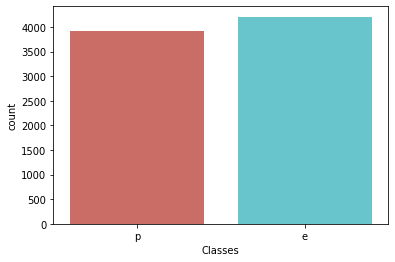

In [5]:
sns.countplot(x = "Classes", data = mushroom_df, palette = "hls")

Text(0, 0.5, 'Frequency of mushroom types')

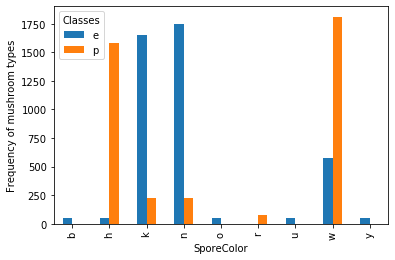

In [6]:
pd.crosstab(mushroom_df["spore-print-color"],mushroom_df["Classes"]).plot(kind='bar')
plt.xlabel('SporeColor')
plt.ylabel('Frequency of mushroom types')

Text(0, 0.5, 'Frequency of mushroom types')

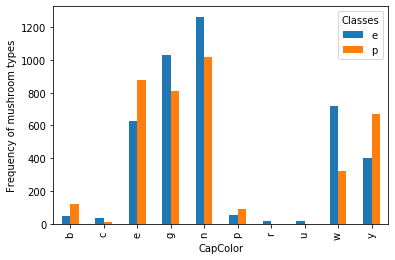

In [7]:
pd.crosstab(mushroom_df["cap-color"],mushroom_df["Classes"]).plot(kind='bar')
plt.xlabel('CapColor')
plt.ylabel('Frequency of mushroom types')

Text(0, 0.5, 'Frequency of mushroom types')

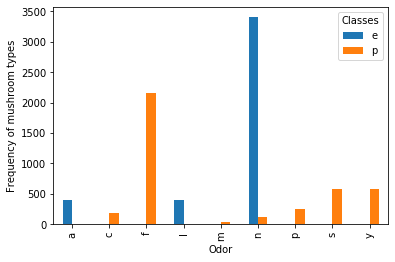

In [8]:
pd.crosstab(mushroom_df["odor"],mushroom_df["Classes"]).plot(kind='bar')
plt.xlabel('Odor')
plt.ylabel('Frequency of mushroom types')

# Cleaning data
### Turining string to numeric datatype

In [9]:
dataFeatures = {"Classes": ["p","e"],
            "cap-shape": ["b","c","x","f","k","s"],
            "cap-surface": ["f","g","y","s"],
            "cap-color": ["n","b","c","g","r","p","u","e","w","y"],
            "bruises": ["t","f"],
            "odor": ["a","l","c","y","f","m","n","p","s"],
            "gill-attachment": ["a","d","f","n"],
            "gill-spacing": ["c","w","d"],
            "gill-size": ["b","n"],
            "gill-color": ["k","n","b","h","g","r","o","p","u","e","w","y"],
            "stalk-shape": ["e","t"],
            "stalk-root": ["b","c","u","e","z","r","?"],
            "stalk-surface-above-ring": ["f","y","k","s"],
            "stalk-surface-below-ring": ["f","y","k","s"],
            "stalk-color-above-ring": ["n","b","c","g","o","p","e","w","y"],
            "stalk-color-below-ring": ["n","b","c","g","o","p","e","w","y"],
            "veil-type": ["p","u"],
            "veil-color": ["n","o","w","y"],
            "ring-number": ["n","o","t"],
            "ring-type": ["c","e","f","l","n","p","s","z"],
            "spore-print-color": ["k","n","b","h","r","o","u","w","y"],
            "population": ["a","c","n","s","v","y"],
            "habitat": ["g","l","m","p","u","w","d"]}

dim = 22
n_classes = 2
n_neighbors = 3
random_state = 13

for key, val in dataFeatures.items():
    zFeature = zip(val, range(len(val)))
    for k, v in zFeature:
        mushroom_df.loc[mushroom_df[key] == k, key] = v

# Splitting for training data, validation data and testing data

In [10]:
np.random.seed(13)

dataVals = mushroom_df.values
X = dataVals[:,1:]
Y = dataVals[:,0]
n = 8124
S = np.random.permutation(n)

# Training samples
Xtr = dataVals[S[:2*n//3], 1:]
Ytr = dataVals[S[:2*n//3], :1]
# Testing samples
x_test = dataVals[S[2*n//3:], 1:]
y_test = dataVals[S[2*n//3:], :1].ravel()

n2 = len(Xtr)
S2 = np.random.permutation(n2)
 
# subsets for training models
x_train= Xtr[S2[:n2//2],:]
y_train= Ytr[S2[:n2//2],:].ravel()
# subsets for validation
x_validation= Xtr[S2[n2//2:],:]
y_validation= Ytr[S2[n2//2:],:].ravel()

# Logistic regression

In [11]:
logMod = LogisticRegression()
logMod.fit(x_train, y_train)
y_pred = logMod.predict(x_test)
conf_matrix, accuracy, recall_array, precision_array = func_confusion_matrix(y_test, y_pred)

print("Confusion Matrix: ")
print(conf_matrix)
print("Average Accuracy: {}".format(accuracy))
print("Per-Class Precision: {}".format(precision_array))
print("Per-Class Recall: {}".format(recall_array))

Confusion Matrix: 
[[1255   47]
 [  98 1308]]
Average Accuracy: 0.9464549483013294
Per-Class Precision: [0.92756837 0.96531365]
Per-Class Recall: [0.96390169 0.93029872]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Multinomial Logistic Regression with L1 penalty

In [12]:
scaler = StandardScaler()
x_trains = scaler.fit_transform(x_train)
x_tests = scaler.transform(x_test)
clf = LogisticRegression(penalty='l1', solver='saga', tol=0.1)
clf.fit(x_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(x_test, y_test)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

y_pred = clf.predict(x_test)

conf_matrix, accuracy, recall_array, precision_array = func_confusion_matrix(y_test, y_pred)

print("Confusion Matrix: ")
print(conf_matrix)
print("Average Accuracy: {}".format(accuracy))
print("Per-Class Precision: {}".format(precision_array))
print("Per-Class Recall: {}".format(recall_array))

Sparsity with L1 penalty: 4.55%
Test score with L1 penalty: 0.9343
Confusion Matrix: 
[[1211   91]
 [  87 1319]]
Average Accuracy: 0.9342688330871491
Per-Class Precision: [0.93297381 0.93546099]
Per-Class Recall: [0.93010753 0.93812233]


# K-nearest neighbors

In [13]:
nca = NeighborhoodComponentsAnalysis(random_state=random_state)
nca.fit(x_train, y_train)

NeighborhoodComponentsAnalysis(callback=None, init='auto', max_iter=50,
                               n_components=None, random_state=13, tol=1e-05,
                               verbose=0, warm_start=False)

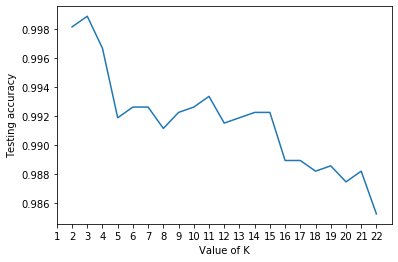

In [14]:
# Run k from 1 to 22 to see the testing accuracy
k_range = range(2,23)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    score = sk.metrics.accuracy_score(y_test, y_pred)
    scores[k] = score
    scores_list.append(score)
    
plt.plot(k_range, scores_list)
plt.xlabel("Value of K")
plt.ylabel("Testing accuracy")
plt.xticks(range(1,23,1));

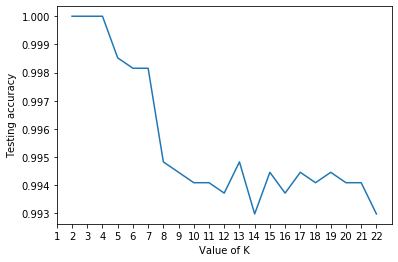

In [15]:
# Run k from 1 to 22 to see the testing accuracy for NeighborhoodComponentsAnalysis
k_range = range(2,23)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(nca.transform(x_train), y_train)
    y_pred = knn.predict(nca.transform(x_test))
    score = sk.metrics.accuracy_score(y_test, y_pred)
    scores[k] = score
    scores_list.append(score)
    
plt.plot(k_range, scores_list)
plt.xlabel("Value of K")
plt.ylabel("Testing accuracy")
plt.xticks(range(1,23,1));

In [16]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
conf_matrix, accuracy, recall_array, precision_array = func_confusion_matrix(y_test, y_pred)

print("Confusion Matrix: ")
print(conf_matrix)
print("Average Accuracy: {}".format(accuracy))
print("Per-Class Precision: {}".format(precision_array))
print("Per-Class Recall: {}".format(recall_array))

Confusion Matrix: 
[[1302    0]
 [   3 1403]]
Average Accuracy: 0.9988921713441654
Per-Class Precision: [0.99770115 1.        ]
Per-Class Recall: [1.         0.99786629]


In [17]:
knn.fit(nca.transform(x_train), y_train)

y_pred = knn.predict(x_test)
conf_matrix, accuracy, recall_array, precision_array = func_confusion_matrix(y_test, y_pred)

print("Confusion Matrix: ")
print(conf_matrix)
print("Average Accuracy: {}".format(accuracy))
print("Per-Class Precision: {}".format(precision_array))
print("Per-Class Recall: {}".format(recall_array))

Confusion Matrix: 
[[1298    4]
 [  12 1394]]
Average Accuracy: 0.9940915805022157
Per-Class Precision: [0.99083969 0.99713877]
Per-Class Recall: [0.9969278  0.99146515]


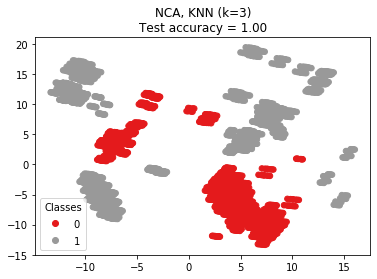

In [18]:
# NCA is an algorithm that uses a technique similar to k-nearest-neighbors to find a space in which 
# neighborhoods of points sharing the same labels are tighter than points with different labels.
# NCA clusters data based on the results of dimensionality reduction on the matrix.
#NCA is attractive for classification because it can naturally handle multi-class problems without any increase
#in the model size, and does not introduce additional parameters that require fine-tuning by the user.

#NCA classification has been shown to work well in practice for data sets of varying size and difficulty. 
#In contrast to related methods such as Linear Discriminant Analysis, NCA does not make any assumptions about 
#the class distributions. The nearest neighbor classification can naturally produce highly irregular decision 
#boundaries.

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components=2,
                                                   random_state=random_state))

knn = KNeighborsClassifier(n_neighbors=n_neighbors)

nca.fit(x_train, y_train)
knn.fit(nca.transform(x_train), y_train)
acc_knn = knn.score(nca.transform(x_test), y_test)
X_embedded = nca.transform(X)

a = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y, s=30, cmap='Set1')
plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format("NCA", n_neighbors, acc_knn))
plt.legend(*a.legend_elements(), loc = "best", title="Classes")
plt.show()

# Support Vector Machine

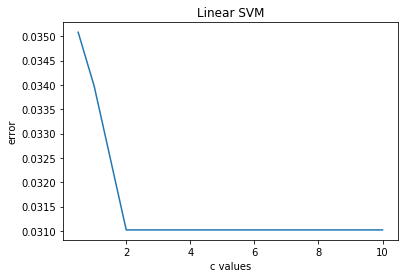

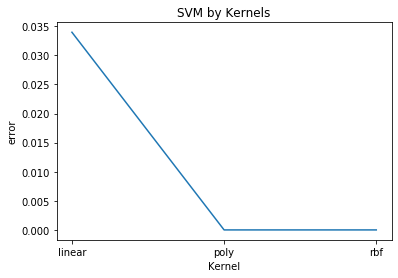

In [19]:
## step 3 Model selection over validation set
# consider the parameters C, kernel types (linear, RBF etc.) and kernel
# parameters if applicable. 
# 3.1 Plot the validation errors while using different values of C ( with other hyperparameters fixed) 
#  keeping kernel = "linear"
c_range = [0.5,1,2,3,4,5,6,7,8,9,10]
svm_c_error = []
for c_value in c_range:
    model = svm.SVC(kernel='linear', C=c_value, gamma = 'auto')
    model.fit(X=x_train, y=y_train)
    error = 1. - model.score(x_validation, y_validation)
    svm_c_error.append(error)
plt.plot(c_range, svm_c_error)
plt.title('Linear SVM')
plt.xlabel('c values')
plt.ylabel('error')
#plt.xticks(c_range)
plt.show()
# 3.2 Plot the validation errors while using linear, RBF kernel, or Polynomial kernel ( with other hyperparameters fixed) 

kernel_types = ['linear', 'poly', 'rbf']
svm_kernel_error = []
for kernel_value in kernel_types:
    model = svm.SVC(kernel=kernel_value, gamma = 'auto')
    model.fit(X=x_train, y=y_train)
    error = 1. - model.score(x_validation, y_validation)
    svm_kernel_error.append(error)

plt.plot(kernel_types, svm_kernel_error)
plt.title('SVM by Kernels')
plt.xlabel('Kernel')
plt.ylabel('error')
plt.xticks(kernel_types)
plt.show()

In [20]:
## step 4 Select the best model and apply it over the testing subset 
best_kernel = 'poly'
best_c = 4
model = svm.SVC(kernel=best_kernel, C=best_c, gamma = 'auto', random_state = random_state)
model.fit(X=x_train, y=y_train)

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=13, shrinking=True, tol=0.001,
    verbose=False)

In [21]:
## step 5 evaluate your results in terms of accuracy, real, or precision. 

y_pred = model.predict(x_test)
conf_matrix, accuracy, recall_array, precision_array = func_confusion_matrix(y_test, y_pred)

print("Confusion Matrix: ")
print(conf_matrix)
print("Average Accuracy: {}".format(accuracy))
print("Per-Class Precision: {}".format(precision_array))
print("Per-Class Recall: {}".format(recall_array))

Confusion Matrix: 
[[1302    0]
 [   0 1406]]
Average Accuracy: 1.0
Per-Class Precision: [1. 1.]
Per-Class Recall: [1. 1.]
